<a href="https://colab.research.google.com/github/carlosmding/project_intro_IA/blob/main/03_modelo_con_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import math
from seaborn import distplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from matplotlib.patches import split_path_inout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

**1. Cargar Dataset**

Se carga el dataset final luego del preprocesamiento. Se cargan los archivos Dataset.csv y y.csv

In [13]:
X = pd.read_csv('Dataset.csv', sep=",") 
y = pd.read_csv('y.csv', sep=",") 

X=X.drop(columns=['Unnamed: 0'])
y=y.drop(columns=['Unnamed: 0'])


**2. Generador de muestras sintéticas**

In [14]:
pca=PCA(n_components=30) 
pca.fit(X) #
X_pca=pca.transform(X)

In [17]:
ros = RandomOverSampler(random_state=42, sampling_strategy=1.0)                          
Xres, yres = ros.fit_resample(X_pca, y)
Xtrain, Xtst, ytrain, ytst = train_test_split(Xres,yres, test_size=0.1) #Se toma el 90 % de los datos para Entrenar
print (Xtrain.shape, ytrain.shape, Xtst.shape, ytst.shape)
X=Xtrain
y=ytrain

(26409, 30) (26409, 1) (2935, 30) (2935, 1)


**3. Calculo pesos de la clase Parametro que se usa para minimizar el efecto del desbalance del dataset**

In [19]:
def dar_peso_clase():
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state = 17)
  Number_Muestras_por_Clase = ytrain.value_counts()
  Number_Muestras_por_Clase = Number_Muestras_por_Clase.sort_index(axis = 0, ascending = True)
  Numero_de_Clases = len(Number_Muestras_por_Clase.index)
  Peso_por_Clase = len(ytrain)/(Numero_de_Clases*Number_Muestras_por_Clase)
  return Peso_por_Clase

**4. Maquina de soporte vectorial** https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

**4.1 Calculo de parametros**

In [20]:
from sklearn.utils.fixes import loguniform
param_grid = {'kernel': ['rbf'], 'C':[1, 10, 20],
              'gamma': [1e-3, 1e-4] ,
              
              } 
#'tol':[1e-3, 1e-4],           
#  'decision_function_shape':['ovo', 'ovr']

svc = svm.SVC(gamma="scale")
clf = GridSearchCV(svc, param_grid, cv=5,n_jobs=2)
clf.fit(X, y) 
parametros = pd.concat([pd.DataFrame(clf.cv_results_["params"]),
                pd.DataFrame(clf.cv_results_["mean_test_score"],
                columns=["Accuracy"])],axis=1)
print(parametros)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    C   gamma kernel  Accuracy
0   1  0.0010    rbf  0.719376
1   1  0.0001    rbf  0.718921
2  10  0.0010    rbf  0.722822
3  10  0.0001    rbf  0.719376
4  20  0.0010    rbf  0.722822
5  20  0.0001    rbf  0.719376


In [21]:
kf = KFold(n_splits=5, random_state = True,shuffle=True)
c=1
weight= dar_peso_clase()
X_test =0
y_test =0
#degree =3 los resultados fueron regulares con el kernel ="poly" , no calcula area AUC

svclassifier = SVC(C=c,kernel="rbf", degree=3, gamma='auto',shrinking=True,tol=0.00010,
                   class_weight = {0: weight[0], 1: weight[1]},
                   decision_function_shape='ovr')

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    modelo = svclassifier.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    print()
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits =6, labels=[0,1],zero_division=1))
    s = roc_auc_score(y_test, modelo.predict(X_test))
    print(f'Best val auc: {s: .4f}')
    print()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[[1240 1433]
 [  53 2556]]
              precision    recall  f1-score   support

           0   0.959010  0.463898  0.625315      2673
           1   0.640762  0.979686  0.774780      2609

    accuracy                       0.718667      5282
   macro avg   0.799886  0.721792  0.700048      5282
weighted avg   0.801814  0.718667  0.699142      5282

Best val auc:  0.7218



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[[1176 1420]
 [  43 2643]]
              precision    recall  f1-score   support

           0   0.964725  0.453005  0.616514      2596
           1   0.650505  0.983991  0.783227      2686

    accuracy                       0.723022      5282
   macro avg   0.807615  0.718498  0.699870      5282
weighted avg   0.804938  0.723022  0.701291      5282

Best val auc:  0.7185



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[[1227 1412]
 [  49 2594]]
              precision    recall  f1-score   support

           0   0.961599  0.464949  0.626820      2639
           1   0.647529  0.981460  0.780268      2643

    accuracy                       0.723400      5282
   macro avg   0.804564  0.723205  0.703544      5282
weighted avg   0.804445  0.723400  0.703602      5282

Best val auc:  0.7232



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[[1236 1421]
 [  58 2567]]
              precision    recall  f1-score   support

           0   0.955178  0.465186  0.625664      2657
           1   0.643681  0.977905  0.776350      2625

    accuracy                       0.719992      5282
   macro avg   0.799429  0.721546  0.701007      5282
weighted avg   0.800373  0.719992  0.700551      5282

Best val auc:  0.7215



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



[[1291 1380]
 [  54 2556]]
              precision    recall  f1-score   support

           0   0.959851  0.483340  0.642928      2671
           1   0.649390  0.979310  0.780935      2610

    accuracy                       0.728461      5281
   macro avg   0.804621  0.731325  0.711932      5281
weighted avg   0.806414  0.728461  0.711135      5281

Best val auc:  0.7313



**Curva ROC Modelo maquina de soporte Vectorial SVC**


Average_presicion_score 0.4942245786782806
Sin entrenar: ROC AUC=0.500
Algoritmo SVC: ROC AUC=0.731



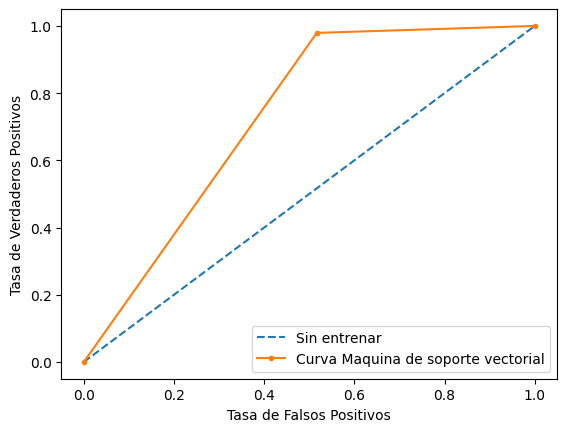

In [22]:
#Curva ROC
classes = svclassifier.predict(X_test)
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs,average='weighted')
svclassifier_auc = roc_auc_score(y_test,classes,average='weighted')
aps = average_precision_score(y_test, ns_probs)

print("Average_presicion_score "+str(aps))
print('Sin entrenar: ROC AUC=%.3f' % (ns_auc))
print('Algoritmo SVC: ROC AUC=%.3f' % (svclassifier_auc))
svclassifier_probs = classes[:]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
svclassifier_fpr, classifier_tpr, _ = roc_curve(y_test, svclassifier_probs)
print()
pyplot.plot(svclassifier_fpr, classifier_tpr, marker='.', label='Curva Maquina de soporte vectorial')
pyplot.xlabel('Tasa de Falsos Positivos')
pyplot.ylabel('Tasa de Verdaderos Positivos')
pyplot.legend()
pyplot.show()
print()